## Analyzing borrowers’ risk of defaulting

Your project is to prepare a report for a bank’s loan division. You’ll need to find out if a customer’s marital status and number of children has an impact on whether they will default on a loan. The bank already has some data on customers’ credit worthiness.

Your report will be considered when building a **credit scoring** of a potential customer. A **credit scoring** is used to evaluate the ability of a potential borrower to repay their loan.

In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Step 1. Open the data file and have a look at the general information. 

In [2]:
data = pd.read_csv('credit_scoring_eng.csv')
data.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,bachelor's degree,0,married,0,F,employee,0,40620.102,purchase of the house
1,1,-4024.803754,36,secondary education,1,married,0,F,employee,0,17932.802,car purchase
2,0,-5623.422610,33,Secondary Education,1,married,0,M,employee,0,23341.752,purchase of the house
3,3,-4124.747207,32,secondary education,1,married,0,M,employee,0,42820.568,supplementary education
4,0,340266.072047,53,secondary education,1,civil partnership,1,F,retiree,0,25378.572,to have a wedding
5,0,-926.185831,27,bachelor's degree,0,civil partnership,1,M,business,0,40922.170,purchase of the house
6,0,-2879.202052,43,bachelor's degree,0,married,0,F,business,0,38484.156,housing transactions
7,0,-152.779569,50,SECONDARY EDUCATION,1,married,0,M,employee,0,21731.829,education
8,2,-6929.865299,35,BACHELOR'S DEGREE,0,civil partnership,1,F,employee,0,15337.093,having a wedding
9,0,-2188.756445,41,secondary education,1,married,0,M,employee,0,23108.150,purchase of the house for my family


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


### Step 2: Preprocess the data.

We don't need the floating point level of precision for total income and days employed, so we'll convert those to integers.

In [4]:
try:
    data['days_employed'] = data['days_employed'].astype('int')
    data['total_income'] = data['total_income'].astype('int')
except:
    print("Check these columns for null values.")
    print("Number of null values for days_employed:", len(data[data['days_employed'].isnull()]))
    print("Number of null values for total_income:", len(data[data['total_income'].isnull()]))

Check these columns for null values.
Number of null values for days_employed: 2174
Number of null values for total_income: 2174


**The days_employed and total_income currently contain null values, which prevent us from converting the non-null values from floating points to integers. We'll come back to this after filling in or removing the null values.**

On first glance, the education column contains multiple values, but these values vary in letter capitalization. Before using it for comparison, I will give the column uniform casing.

In [5]:
data['education'] = data['education'].str.upper()
data['education'].value_counts()

SECONDARY EDUCATION    15233
BACHELOR'S DEGREE       5260
SOME COLLEGE             744
PRIMARY EDUCATION        282
GRADUATE DEGREE            6
Name: education, dtype: int64

In the dataframe info output, we see that days_employed and total_income have the same number of null values. Let's check to see if there is some kind of pattern with these rows.

In [6]:
# Should return an empty series object
data[data['days_employed'].isnull()]['total_income'].value_counts()

Series([], Name: total_income, dtype: int64)

In [7]:
data[data['days_employed'].isnull()]['income_type'].value_counts()

employee         1105
business          508
retiree           413
civil servant     147
entrepreneur        1
Name: income_type, dtype: int64

In [8]:
data[data['days_employed'].isnull()]['education'].value_counts(normalize = True)

SECONDARY EDUCATION    0.708372
BACHELOR'S DEGREE      0.250230
SOME COLLEGE           0.031739
PRIMARY EDUCATION      0.009660
Name: education, dtype: float64

In [9]:
data[data['days_employed'].notnull()]['education'].value_counts(normalize = True)

SECONDARY EDUCATION    0.707612
BACHELOR'S DEGREE      0.243708
SOME COLLEGE           0.034882
PRIMARY EDUCATION      0.013488
GRADUATE DEGREE        0.000310
Name: education, dtype: float64

**Based on the fact that there is no clear distinction between the non-null data points and the null data points, we can safely assume that the days_employed and total_income null values are distributed randomly across the dataset. For this reason, we can fill in null values using mean or median.**

One possible method to fill in these missing values is to replace the total income values with **the mean value for total income for the corresponding income type**, i.e. replace total income missing values for retirees with the mean value of income for all retirees in the dataset. 

In [10]:
def fill_missing_values(data, income_type_list):
    
    for income_type in income_type_list:
        data.loc[(data['income_type'] == income_type) & (data['total_income'].isnull()), 'total_income'] = (
            data.loc[(data['income_type'] == income_type) & (data['total_income'].notnull()), 'total_income'].mean())

        data.loc[(data['income_type'] == income_type) & (data['days_employed'].isnull()), 'days_employed'] = (
            data.loc[(data['income_type'] == income_type) & (data['days_employed'].notnull()), 'days_employed'].mean())
    return data

In [11]:
income_type_list = data[data['days_employed'].isnull()]['income_type'].unique().tolist()
print("Income types of null values:", income_type_list)

Income types of null values: ['retiree', 'civil servant', 'business', 'employee', 'entrepreneur']


In [12]:
data = fill_missing_values(data, income_type_list)
print("Information for updated dataframe:\n")
print(data.info())

Information for updated dataframe:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       21525 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        21525 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB
None


Now that we have filled in our null values, we can now convert the total_income and days_employed columns to integer values.

In [13]:
data['days_employed'] = data['days_employed'].astype('int')
data['total_income'] = data['total_income'].astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       21525 non-null int64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        21525 non-null int64
purpose             21525 non-null object
dtypes: int64(7), object(5)
memory usage: 2.0+ MB


### Takeaway #1: Why were these missing values present?

Due to the randomness of the data points with missing values for days_employed and total_income, I believe that some individuals simply forgot to input this data when filling out their loan application. Since the two fields were always missing together, they were likely part of the same questions/grouping of questions that some individuals didn't fill out. 

#### Step 2.1: Deal with negative days_employed values.

In [14]:
# Function to make viewing basic statistical measures for a given feature easier
def statistical_summary(column):
    print("Min {}: {:.2f}".format(column, min(data[column])))
    print("Max {}: {:.2f}".format(column, max(data[column])))
    print("Median {}: {:.2f}".format(column, data[column].median()))
    print("Average {}: {:.2f}".format(column, data[column].mean()))
    print("Standard deviation of {}: {:.2f}".format(column, data[column].std()))

In [15]:
statistical_summary('days_employed')

Min days_employed: -18388.00
Max days_employed: 401755.00
Median days_employed: -1355.00
Average days_employed: 63490.01
Standard deviation of days_employed: 141167.80


In [16]:
print("Number of data points with negative days employed:", len(data[data['days_employed'] < 0]))
print("% of data points with negative days employed: {:.2%}".format(len(data[data['days_employed'] < 0])/len(data)))

Number of data points with negative days employed: 17667
% of data points with negative days employed: 82.08%


So **over 82%** of our data points contain negative values for days employed. This leads me to believe that some sort of technical error led to the negative values we're seeing. 

In [17]:
negative_points = data[data['days_employed'] < 0]
negative_points.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437,42,BACHELOR'S DEGREE,0,married,0,F,employee,0,40620,purchase of the house
1,1,-4024,36,SECONDARY EDUCATION,1,married,0,F,employee,0,17932,car purchase
2,0,-5623,33,SECONDARY EDUCATION,1,married,0,M,employee,0,23341,purchase of the house
3,3,-4124,32,SECONDARY EDUCATION,1,married,0,M,employee,0,42820,supplementary education
5,0,-926,27,BACHELOR'S DEGREE,0,civil partnership,1,M,business,0,40922,purchase of the house


In [18]:
negative_points['years_employed'] = -1 * negative_points['days_employed'] / 365.25
negative_points.head()

/Users/nyleashraf/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,years_employed
0,1,-8437,42,BACHELOR'S DEGREE,0,married,0,F,employee,0,40620,purchase of the house,23.099247
1,1,-4024,36,SECONDARY EDUCATION,1,married,0,F,employee,0,17932,car purchase,11.017112
2,0,-5623,33,SECONDARY EDUCATION,1,married,0,M,employee,0,23341,purchase of the house,15.394935
3,3,-4124,32,SECONDARY EDUCATION,1,married,0,M,employee,0,42820,supplementary education,11.290897
5,0,-926,27,BACHELOR'S DEGREE,0,civil partnership,1,M,business,0,40922,purchase of the house,2.535250


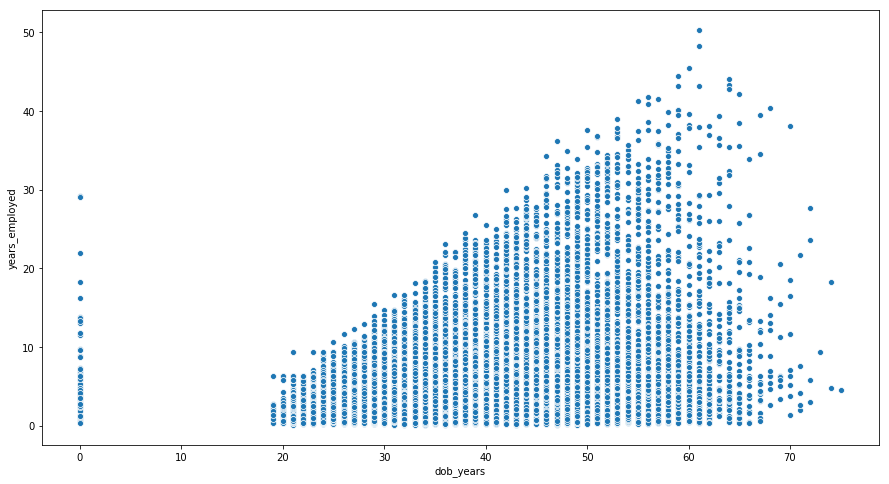

In [19]:
plt.figure(figsize=(15,8))
sns.scatterplot(x='dob_years', y='years_employed', data=negative_points)

While the pattern isn't as apparent as I had hypothesized, there is a positive linear correlation between age and years employed. This could mean that the negative values were simply errors and that taking the absolute value of those numbers will fix our problems. However, we do have some clear outliers -- people that have an age of 0. We'll need to remove those from our dataset.

In [20]:
print("Number of data points with age = 0:", len(data[data['dob_years'] == 0]))
print("% of data points with age = 0: {:.2%}".format(len(data[data['dob_years'] == 0]) / len(data)))

Number of data points with age = 0: 101
% of data points with age = 0: 0.47%


Since these data points are such a small percentage of the overall dataset, we can remove these points, rather than approximating in missing values.

*However, if we did want to fill in the missing values, we could take the mean difference between dob_years and years_employed and add that number to the years_employed for each individual with a missing age to approximate.*

In [21]:
data = data[data['dob_years'] > 0]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21424 entries, 0 to 21524
Data columns (total 12 columns):
children            21424 non-null int64
days_employed       21424 non-null int64
dob_years           21424 non-null int64
education           21424 non-null object
education_id        21424 non-null int64
family_status       21424 non-null object
family_status_id    21424 non-null int64
gender              21424 non-null object
income_type         21424 non-null object
debt                21424 non-null int64
total_income        21424 non-null int64
purpose             21424 non-null object
dtypes: int64(7), object(5)
memory usage: 2.1+ MB


Going back to our other insight from the scatterplot, let's replace all negative values in the years_employed column with its absolute value.

In [22]:
data['days_employed'] = data['days_employed'].abs()

In [23]:
statistical_summary('days_employed')

Min days_employed: 24.00
Max days_employed: 401755.00
Median days_employed: 2326.00
Average days_employed: 67322.14
Standard deviation of days_employed: 139343.31


### Takeaway #2: Why were the majority of values in the days_employed column negative? 

I believe that there were technical errors in the process of data input that led to the negative values. When we looked at the scatterplot of years_employed vs. dob_years, there was a clear positive correlation between the two variables, which is expected -- the older an individual is, the longer she has likely worked. Since the years_employed data was created with the absolute value of the days_employed column, we can assume that the negative value was simply an error in data input and the absolute value of those data points is correct.

#### Step 2.2: Deal with negative children values.

In [24]:
statistical_summary('children')

Min children: -1.00
Max children: 20.00
Median children: 0.00
Average children: 0.54
Standard deviation of children: 1.38


In [25]:
print("Number of individuals with children = -1:", len(data[data['children'] < 0]))
print("% of individuals with children = -1: {:.2%}".format(len(data[data['children'] < 0]) / len(data)))
print("Average age of individuals with childen = -1: {:.2f}".format(data[data['children'] < 0]['dob_years'].mean()))
print("Min age of individuals with childen = -1: {:.2f}".format(data[data['children'] < 0]['dob_years'].min()))
print("Max age of individuals with childen = -1: {:.2f}".format(data[data['children'] < 0]['dob_years'].max()))

Number of individuals with children = -1: 47
% of individuals with children = -1: 0.22%
Average age of individuals with childen = -1: 42.57
Min age of individuals with childen = -1: 23.00
Max age of individuals with childen = -1: 69.00


Looking at the average age of individuals with number of children as -1, it seems safe to assume that the negative values are due to errors in data entry, and taking the absolute value of these values would give us an accurate number of children for these individuals.

In [26]:
data['children'] = data['children'].abs()

In [27]:
statistical_summary('children')

Min children: 0.00
Max children: 20.00
Median children: 0.00
Average children: 0.54
Standard deviation of children: 1.38


### Step 3: Categorize Data

#### Step 3.1: Income Level

In [28]:
statistical_summary('total_income')

Min total_income: 3306.00
Max total_income: 362496.00
Median total_income: 24307.00
Average total_income: 26789.36
Standard deviation of total_income: 15682.55


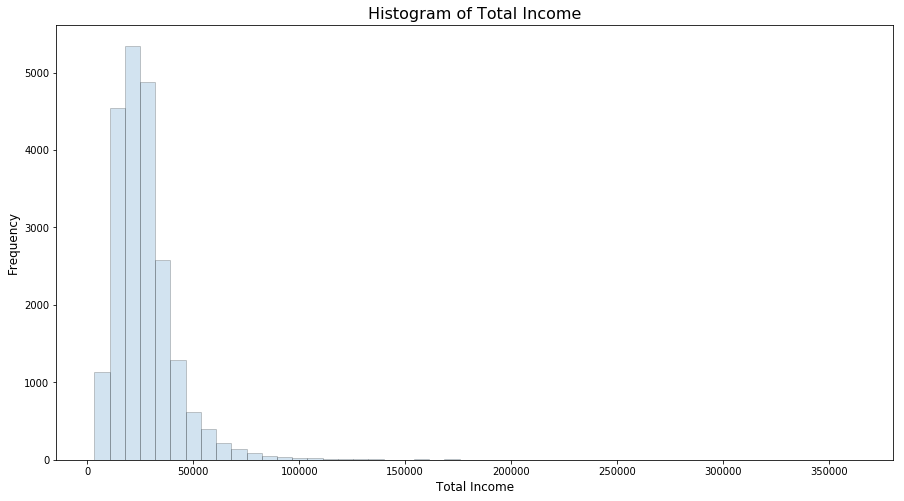

In [29]:
# Histogram of total income frequency across dataset
total_income = data['total_income'].to_numpy()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}
fig, ax = plt.subplots(figsize=(15, 8))
sns.distplot(total_income, bins=50, kde=False, ax=ax, hist_kws=hist_kws)
ax.set_title('Histogram of Total Income', fontsize=16)
ax.set_xlabel('Total Income', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
plt.show()

The histogram shows that although our max salary is above \\$300,000, the vast majority of our income data lies below \\$100,000. I'll plot a CDF (cumulative density function) to help provide some insight into how to categorize our income data.

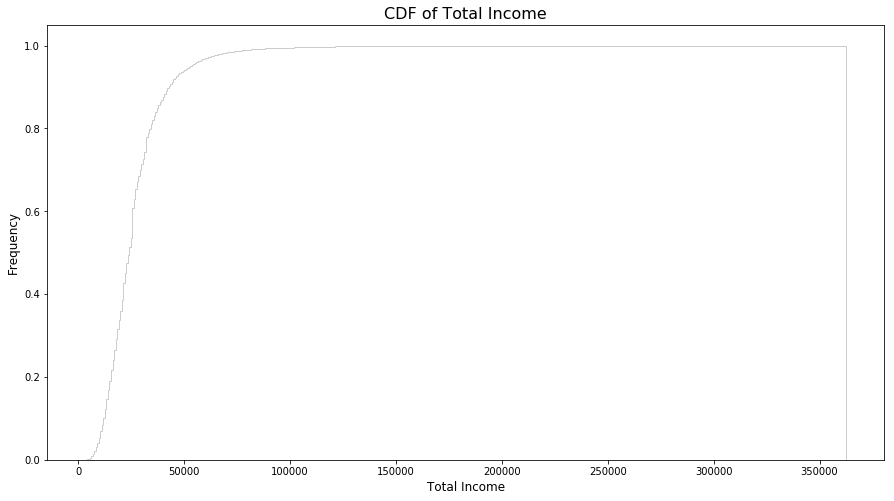

In [30]:
hist_kws={'histtype': 'step', 'edgecolor':'black', 'alpha': 0.2, 'cumulative': True, 'density': 1}
fig, ax = plt.subplots(figsize=(15, 8))
sns.distplot(total_income, bins=500, kde=False, ax=ax, hist_kws=hist_kws)
ax.set_title('CDF of Total Income', fontsize=16)
ax.set_xlabel('Total Income', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
plt.show()

In [31]:
# Get the data points for each percentile in data (starting with 25, 33, 50, 67, 75)
percentile_list = [25, 33, 50, 67, 75]
for percentile in percentile_list:
    print("Percentile {}: {:.2f}".format(percentile, np.percentile(total_income, percentile)))

Percentile 25: 17251.50
Percentile 33: 19577.59
Percentile 50: 24307.00
Percentile 67: 28419.82
Percentile 75: 32386.00


For now, we'll categorize our income data into three groupings: **low income** (up to 33rd percentile), **medium income** (33rd to 67th percentile), and **high income** (higher than 67th percentile). We're going to see high variation in the high income group, so that may be something to watch out for when drawing conclusions from the data.

In [32]:
income_dict = {'low income': np.percentile(total_income, 33), 'medium income': np.percentile(total_income, 67)}

def define_income_level(row, income_dict):
    
    income = row['total_income']
    
    if income <= income_dict['low income']:
        return 'low income'
    elif income_dict['low income'] < income <= income_dict['medium income']:
        return 'medium income'
    return 'high income'

data['income_level'] = data.apply(define_income_level, income_dict = income_dict, axis = 1)
data.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,income_level
0,1,8437,42,BACHELOR'S DEGREE,0,married,0,F,employee,0,40620,purchase of the house,high income
1,1,4024,36,SECONDARY EDUCATION,1,married,0,F,employee,0,17932,car purchase,low income
2,0,5623,33,SECONDARY EDUCATION,1,married,0,M,employee,0,23341,purchase of the house,medium income
3,3,4124,32,SECONDARY EDUCATION,1,married,0,M,employee,0,42820,supplementary education,high income
4,0,340266,53,SECONDARY EDUCATION,1,civil partnership,1,F,retiree,0,25378,to have a wedding,medium income
5,0,926,27,BACHELOR'S DEGREE,0,civil partnership,1,M,business,0,40922,purchase of the house,high income
6,0,2879,43,BACHELOR'S DEGREE,0,married,0,F,business,0,38484,housing transactions,high income
7,0,152,50,SECONDARY EDUCATION,1,married,0,M,employee,0,21731,education,medium income
8,2,6929,35,BACHELOR'S DEGREE,0,civil partnership,1,F,employee,0,15337,having a wedding,low income
9,0,2188,41,SECONDARY EDUCATION,1,married,0,M,employee,0,23108,purchase of the house for my family,medium income


#### Step 3.2: Children

In order to find whether having children impacts ability to pay off a loan, we need to create a binary variable that returns true (or some other value) if individual has children, and false (or some other value) if individual does not have children.

In [33]:
def define_children_groups(row):
    
    num_children = row['children']
    if num_children > 0:
        return 'has children'
    return 'no children'

data['children_group'] = data.apply(define_children_groups, axis = 1)
data.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,income_level,children_group
0,1,8437,42,BACHELOR'S DEGREE,0,married,0,F,employee,0,40620,purchase of the house,high income,has children
1,1,4024,36,SECONDARY EDUCATION,1,married,0,F,employee,0,17932,car purchase,low income,has children
2,0,5623,33,SECONDARY EDUCATION,1,married,0,M,employee,0,23341,purchase of the house,medium income,no children
3,3,4124,32,SECONDARY EDUCATION,1,married,0,M,employee,0,42820,supplementary education,high income,has children
4,0,340266,53,SECONDARY EDUCATION,1,civil partnership,1,F,retiree,0,25378,to have a wedding,medium income,no children
5,0,926,27,BACHELOR'S DEGREE,0,civil partnership,1,M,business,0,40922,purchase of the house,high income,no children
6,0,2879,43,BACHELOR'S DEGREE,0,married,0,F,business,0,38484,housing transactions,high income,no children
7,0,152,50,SECONDARY EDUCATION,1,married,0,M,employee,0,21731,education,medium income,no children
8,2,6929,35,BACHELOR'S DEGREE,0,civil partnership,1,F,employee,0,15337,having a wedding,low income,has children
9,0,2188,41,SECONDARY EDUCATION,1,married,0,M,employee,0,23108,purchase of the house for my family,medium income,no children


#### Step 3.3: Marital Status, Loan Purpose

In [34]:
data['family_status'].value_counts()

married              12331
civil partnership     4156
unmarried             2797
divorced              1185
widow / widower        955
Name: family_status, dtype: int64

In [35]:
data['purpose'].value_counts()

wedding ceremony                            792
having a wedding                            773
to have a wedding                           769
real estate transactions                    673
buy commercial real estate                  661
buying property for renting out             651
transactions with commercial real estate    649
housing transactions                        647
purchase of the house                       641
housing                                     641
purchase of the house for my family         640
construction of own property                633
property                                    630
transactions with my real estate            630
building a real estate                      623
buy real estate                             621
building a property                         620
purchase of my own house                    619
housing renovation                          610
buy residential real estate                 604
buying my own car                       

Likely due to custom responses from loan seekers, the purpose column has many "duplicates" that vary in word/sentence structure but convey the same idea. There are four overarching purposes: **wedding, real estate purchases, car purchases, and education.** 

In [36]:
def purpose_grouping(row):
    
    purpose = row['purpose']
    if 'educat' in purpose or 'university' in purpose:
        return 'university tuition'
    elif 'car' in purpose:
        return 'car purchase'
    elif 'wedding' in purpose:
        return 'wedding'
    elif 'real estate' in purpose or 'property' in purpose or 'hous' in purpose:
        return 'property'
    return purpose

data['purpose_group'] = data.apply(purpose_grouping, axis = 1)
data['purpose_group'].value_counts()

property              10793
car purchase           4293
university tuition     4004
wedding                2334
Name: purpose_group, dtype: int64

While this brute-force approach works in this scenario, lemmatization would likely be necessary in a situation with more complex variation in word/sentence structure. 

### Step 4: Identify Relationships between Features

#### Is there a connection between having kids and repaying a loan on time?

In [37]:
children_pivot = data.pivot_table(
    index = 'children_group', values = 'debt', aggfunc = np.mean).sort_values(by = 'debt')
children_pivot['count'] = data.groupby('children_group')['children_group'].agg('count')
children_pivot['age'] = data.groupby('children_group')['dob_years'].agg('mean')
print(children_pivot)

                    debt  count        age
children_group                            
no children     0.075142  14080  46.488139
has children    0.091912   7344  37.763753


In [38]:
children_pivot = data.pivot_table(
    index = 'children_group', columns = 'purpose_group', values = 'debt', aggfunc = np.mean)
print(children_pivot)

purpose_group   car purchase  property  university tuition   wedding
children_group                                                      
has children        0.108666  0.081857             0.10292  0.089421
no children         0.085241  0.067072             0.08694  0.073377


#### Is there a connection between marital status and repaying a loan on time?

In [39]:
marital_pivot = data.pivot_table(
    index = 'family_status', values = 'debt', aggfunc = np.mean).sort_values(by = 'debt')
marital_pivot['count'] = data.groupby('family_status')['family_status'].agg('count')
marital_pivot['age'] = data.groupby('family_status')['dob_years'].agg('mean')
print(marital_pivot)

                       debt  count        age
family_status                                
widow / widower    0.064921    955  56.809424
divorced           0.071730   1185  45.902110
married            0.075176  12331  43.737815
civil partnership  0.092878   4156  42.343359
unmarried          0.097605   2797  38.588845


#### Is there a connection between income level and repaying a loan on time?

In [40]:
income_pivot = data.pivot_table(
    index = 'income_level', values = 'debt', aggfunc = np.mean).sort_values(by = 'debt')
income_pivot['count'] = data.groupby('income_level')['income_level'].agg('count')
print(income_pivot)

                   debt  count
income_level                  
high income    0.073550   7070
low income     0.081612   7070
medium income  0.087315   7284


#### How do different loan purposes affect timely loan repayment?

In [41]:
purpose_pivot = data.pivot_table(
    index = 'purpose_group', values = 'debt', aggfunc = np.mean).sort_values(by = 'debt')
purpose_pivot['count'] = data.groupby('purpose_group')['purpose_group'].agg('count')
print(purpose_pivot)

                        debt  count
purpose_group                      
property            0.072176  10793
wedding             0.078835   2334
university tuition  0.092408   4004
car purchase        0.093175   4293


#### Is there a connection between education level and repaying a loan on time? 

In [42]:
education_pivot = data.pivot_table(
    index = 'education', values = 'debt', aggfunc = np.mean).sort_values(by = 'debt')
education_pivot['count'] = data.groupby('education')['education'].agg('count')
print(education_pivot)

                         debt  count
education                           
GRADUATE DEGREE      0.000000      6
BACHELOR'S DEGREE    0.053014   5225
SECONDARY EDUCATION  0.089459  15169
SOME COLLEGE         0.091644    742
PRIMARY EDUCATION    0.109929    282


### Step 5: Overall Conclusions

In this portion of the notebook, I will **outline the conclusions** reached during Step 4 of this notebook, and attempt to **explain why we see these relationships**.

Whether or not you have children has some bearing on your ability to pay back your loans on time -- those with children in our dataset were more likely to miss loan payments than those without children. I actually expected the opposite to be true on the premise that individuals with children are older and more likely to have stable finances. However, in the *children_pivot* pivot table, we see that **on average, the age of those without children is 9 years lower than those with children.** This is a surprising revelation but makes sense -- **stability and maturity of finances likely plays the greatest role in ability to pay back loans on time**, and the data here proves that point.

When looking at the impact of marital status on loan repayment, we see **widowers are least likely to miss loan payments, while unmarried individuals are the most likely to miss payments**. Once again, when looking through the lens of age and financial maturity, this makes sense -- we actually see **a linear relationship between age and ability to repay loans on time**. 

Income level plays a clear factor in ability to repay loans on time -- **high income individuals are less likely to miss loan repayment, while low income individuals are more likely to miss loan repayments**. However, the difference between the two groups isn't as large as expected. This is likely due to the bank filtering out higher-risk individuals from the low income group using data that is not available to us in this dataset (i.e. credit score).

Different loan purposes also affects loan repayment. **While individuals taking out loans for weddings and real estate are less likely to miss loan payments, those taking out loans for university tuition or cars are more likely to miss their payments.** This is likely due to the fact that university tuition has no guaranteed ROI, and there have been extensive studies that report the increasing cost of college and the low salaries for many new grads. Furthermore, cars are more likely to be a splurge purchase, which explains why car loans are less likely to be paid back on time.

Finally, education level has a huge impact on loan repayments. If we exclude graduate degree holders, some college, and primary education individuals (due to low sample size), the difference just between Bachelor's degree holders and secondary education individuals is huge. This makes sense in the context of income -- those with a college education are more likely to be in the medium-to-high income bracket.